# Chapter 4 – Training Linear Models

In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


matplotlib.rc('font', family='AppleGothic')  # MacOS
plt.rcParams['axes.unicode_minus'] = False


### 4.4.1 정규 방정식<sub>normal equation</sub>

(단, *invertible* 할때 = 각 subspace 들이 독립일 때)

#### 테스트 데이터 생성

In [2]:
X = 2* np.random.rand(100, 1) # 100 row, 1 col
y = 4 + 3*X  + np.random.randn(100,1) # 100 row, 1col

In [3]:
print('X :' , X[:5] )

X : [[0.74908024]
 [1.90142861]
 [1.46398788]
 [1.19731697]
 [0.31203728]]


In [4]:
print('y :' , y[:5] )

y : [[6.33428778]
 [9.40527849]
 [8.48372443]
 [5.60438199]
 [4.71643995]]


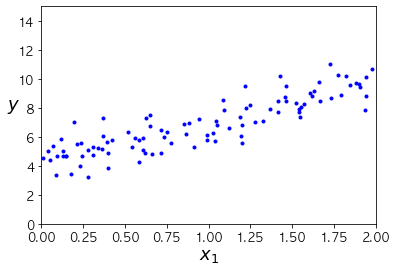

In [5]:
plt.plot(X,y, "b.")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize=18)
plt.axis([0,2, 0, 15])
plt.show()

In [6]:
X_b = np.c_[np.ones((100,1)), X] # X0 = 1 을 추가 해준다
theta_best = np.dot(np.dot(np.linalg.inv(np.dot(X_b.T, X_b)), X_b.T), y)

In [7]:
X_b[:5]

array([[1.        , 0.74908024],
       [1.        , 1.90142861],
       [1.        , 1.46398788],
       [1.        , 1.19731697],
       [1.        , 0.31203728]])

In [8]:
theta_best

array([[4.21509616],
       [2.77011339]])

$\theta_0 = 4.215$ , $\theta_1 = 2.770$  
원래의 방적식은 $y = 4 + 3x_1$ 
>잡음이 섞인 결과가 도출 됨

In [9]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = np.dot(X_new_b, theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

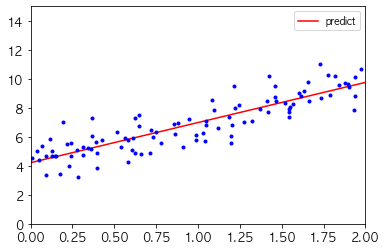

In [10]:
plt.plot(X_new, y_predict, "r-", label = "predict")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.legend()
plt.show()

#### 사이킷런

In [11]:
from sklearn.linear_model import LinearRegression

lin_reg= LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [12]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

`LinearRegression`은 `scipy.linalg.lstsq()` 함수 **최소 제곱<sub>least squares</sub>**을 기반으로 함

In [13]:
theta_best_svd, residuals, rank,s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

위 함수는 $\hat{\theta} = X^+ y$를 계산한다. 여기서 $X^+$는 X의 **유사역행렬**<sub>pseudoinverse</sub>를 가르킨다.  
`np.linalge.pinv()`를 사용해서 유사역행렬을 직접 구할 수 있다.

In [14]:
np.linalg.pinv((X_b)).dot(y)

array([[4.21509616],
       [2.77011339]])

$ X^+ $(유사 역행렬)은 SVD에서 구해지는 값.   
정규 방정식<sub>normal equation</sub>에서 $Col A$의 Subspace에서 종속(dependent) 한 관계가 존재 할 때, 값을 구 할 수 없었는데 SVD는 역행렬이 존재 하지 않아도 유사 역행렬은 항상 구할 수 있다.

### 4.1.2 Computational Complexity
정규 방정식<sub>normal equation</sub>에서는 $ (n+1) * (n+1) $ 횟수 만큼의 연산($ X^{T} X $)을 수행한다. ($n$은 Column, 특성 수).   
이러한 역행렬을 계산하는 계산복잡도<sub>Computational Complexity</sub> 은 일 반적으로 $ O(n^{2.4})$ ~$ O(n^{3}) $  
Sklearn의 `LinearRegression` 클래스가 사용하는 SVD 방식은 $O(n^2)$이다

## 4.2 경사 하강법
경사 하강법<sub>gradient descent</sub>의 기본 아이디어는 *Cost Function*을 최소화 하기 위해 반복적으로 파라미터를 조정해 가는 것  
*parameter* 벡터 $ \theta $ 에 대해 *Cost Function*의 현재 Gradient를 계산 하여, Gradient가 감소되는 방향으로 전진힌다. Gradient가 0에 도달 하면 최솟값에 도달 한 것  
** 무작위 초기화 ** <sub>random initialization</sub>: $\theta$의 값을 임의의 값으로 시작해서 한 번에 조금씨 Cost Function(ex. MSE)이 감쇠되는 방향으로 진행하여 최소값을 찾는다

경사 하강법에서 중요한 하이퍼파라미터는 **학습률**(learning rate, $\eta$)이다. 학습률이 너무 작으면 수렴하는데까지 시간이 오래걸리고, 학습률이 너무 크면 발산하게 된다. 보통 로그 스케일로 0.001($10^{-3}$), 0.001($10^{-2}$)와 같이 지정한다.

>경사 하강법을 사용할 때는 반드시 모든 특성(feature)들이 같은 스케일을 가지도록 해야한다(Standard 또는 MinMax 등). 그렇지 않으면 학습시간이 오래걸리게 된다.   


<img src="./images/gd.gif" width="500">

이를 모델의 **파라미터 공간**<sub>parameter space</sub>에서 파라미터 조합을 찾는다 라고 한다

### 4.2.1 경사 하강법

$$
\frac{\partial}{\partial w_j} MSE(\mathbf{W}) = \frac{2}{m} \sum_{i=1}^{m}{\left( \mathbf{W}^{T} \cdot \mathbf{x}_{i} - y_{i}\right)}x_{ij}
$$

위 편도함수를 계한 하는 대신 **그라디언트 벡터** $\nabla_{\mathbf{W}} \text{MSE}(\mathbf{\theta}) $를 계산한다. $\nabla_{\mathbf{W}} \text{MSE}(\mathbf{\theta}) $는 각 비용 함수의 *Col A*의 특성(subsapce) 마다 편도함수를 모두 담고 있다. 

$$
\nabla_{\mathbf{W}} \text{MSE}(\mathbf{W}) = \begin{bmatrix} \frac { \partial  }{ \partial w_{ i } } { MSE }(W) \\ \vdots \\ \frac { \partial  }{ \partial w_{ i } } { MSE }(W) \end{bmatrix} = \frac{2}{m} \mathbf{X}^{T} \cdot \left( \mathbf{X} \cdot \mathbf{W} - \mathbf{y} \right)
$$

#### 경사 하강법 Step

$$
\mathrm{W} \leftarrow \mathrm{W} - \eta \nabla_{\mathbf{W}} \text{MSE}(\mathbf{W}) \Longleftrightarrow 
 \mathrm{W} \leftarrow \mathrm{W} - \eta \frac{\partial L}{\partial \mathrm{W}} 
$$

In [15]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [16]:
theta

array([[4.21509616],
       [2.77011339]])

#### 여러 학습룰에 따른 경사 하강법

In [17]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

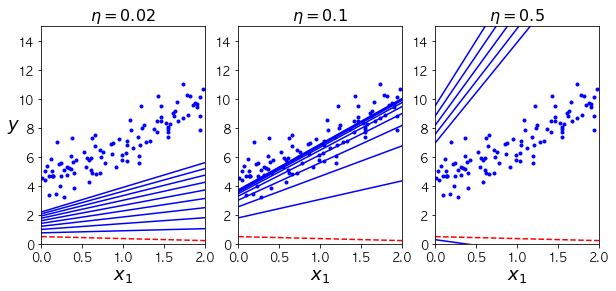

In [18]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

- 학습률이 너무 작다(왼쪽): Optimal에 도달하는데 오랜 시간 소요(최적화 무의미)
- 학습률이 적당하다: 최적에 수럼
- 학습률이 너무 크다(오른쪽): 발산 해버린다.

#### iteration 횟수 설정 방법
반복 횟수를 아주 크게 설정하고, Gradient Vector가 아주 작아지면(기울기가 아주 작아지면), 즉 벡터의 Norm이 어떤 값 $\varepsilon $(허용오차<sub> tolerance</sub>)보다 작아지면 경사하강법이 거의 최솟값에 도달한 것이므로 알고리즘 중지한다.

### 4.2.2 확률적 경사 하강법 <sub> Stochastic Gradient Descent</sub>  
배치 경사 하강법의 단점은 각 스텝(iter)에서 모든 훈련 세트를 사용 -> 매우 느리다.   


**확률적 경사 하강법**(Stochastic Gradient Descent)은 매 스텝(iter)에서 랜덤하게 하나의 데이터(샘플)을 선택해 Gradient Descent를 계산한다.  
따라서, 전체 데이터를 이용해 GD를 계산하는 것보다 속도는 빠르지만 훨씬 불안정하다.   
비용 함수(Loss Function)가 최소값에 수렴할 때까지 부드럽게 감소하지 않고, 위아래로 요동치면서 평균적으로 감소한다.  
  
SGD는 비용함수가 매우 불규칙 할때, 알고리즘이 Local Minium을 건너 뛰도록 도와주므로, SGD가 BGD보다 Local Minium에 빠지 확률이 적고 Global Minium에 도달할 가능성이 높다.  

하지만,  Global Minium $\neq$ Global Optimal이다. 즉, Global Minium을 잘 탈출 시켜 주지만, BGD보다 Global Optimal을 찾을 가능성이 낮다. 이를 해결 하기 위해서 학습률을 점진적으로 감소 시키는 **learning rate decay** 기법을 사용한다. 

learning rate decay(또는 learning rate schedule)는 학습을 시작할 때는 학습률을 크게하고, 점진적으로 학습률을 줄여 전역 최소값에 도달하게 하는 방법이다.


In [19]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

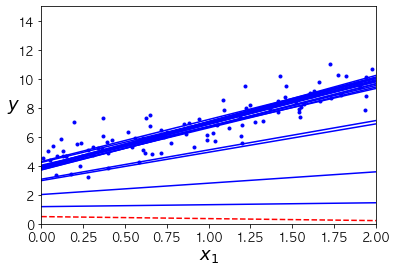

In [20]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                   
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                              
plt.show()                                           

In [21]:
theta

array([[4.21076011],
       [2.74856079]])

sklearn에서 SGD 방식으로 선형회귀를 사용하기 위해서는 기본값으로 MSE 함수를 최적화 하는 `SGDRegressor`를 사용한다.

In [22]:
from sklearn.linear_model import SGDRegressor
# 최대 1000번의 epoch, 허용오차: 0.001, 학습률: 0.1
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [23]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

### 4.2.3 미니배치 경사 하강법<sub>Mini-batch gradient descent</sub>

**미니배치 경사 하강법**(Mini-batch Gradient Descent)은 각 스텝에서 전체 Train Set을  미니배치(mini-batch), 즉 작은 데이터셋을 추출한 뒤 Gradient를 계산하는 방법이다. 미니배치 경사하강법의 장점은 행렬 연산에 최적화된 하드웨어, GPU에서 빠르게 수행되는 것이다. 

미니배치 경사 하강법은 SGD에 비해 덜 불규칙하게 감소하지만, local minimum에 빠질 확률은 높은 경우가 있다.

In [24]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [25]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

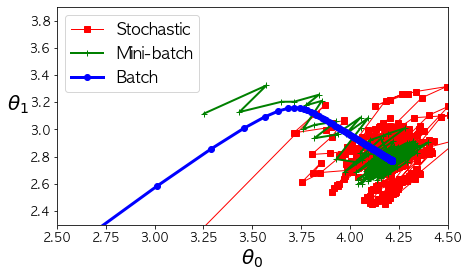

In [26]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

모두 최소값 긑처에 도달했지만, BGD가 Global Optimal에 멈춘 반면,  
SGD와 미니배치 경사 하강법은 근처에서 맴돌고 있다. -> learning schedule 필요

| Algorithm | m is bigger | Supports external memory | n is bigger | num of hyperparameter | Scaling required | Sklearn |
|-|-|-|-|-|-|-|
| Normal Equation | Fast | No | Slow | 0 | No | N/A |
| SVD | Fast | No | Slow | 0 | No | LinearRegression |
| BGD | Slow | No | Fast | 2 | Yes | SGDRegressor |
| SGD | Fast | Yes | Fast | ≥2 | Yes | SGDRegressor |
| Mini-Batch SGD | Fast | Yes | Fast | ≥2 | Yes | SGDRegressor |

#### 배치 경사 하강법 (Batch Gradient Descent: BGD)
배치 경사 하강법이란, 전체 학습 데이터를 하나의 배치로(배치 크기가 n) 묶어 학습시키는 경사 하강법  
(**배치**: **GPU가 한번에 처리하는 데이터의 묶음**)

전체 데이터에 대한 모델의 오차의 평균을 구한 다음, 이를 이용하여 미분을 통해 경사를 산출, 최적화를 진행한다.
보통 딥러닝 라이브러리에서 배치를 지정하지 않으면 이 방법을 쓰고 있다고 생각할 수 있다.

배치 경사 하강법의 특징은 아래와 같다.

- 전체 데이터를 통해 학습시키기 때문에, 가장 업데이트 횟수가 적다. (1 Epoch 당 1회 업데이트)
- 전체 데이터를 모두 한 번에 처리하기 때문에, 메모리가 가장 많이 필요하다.
- 항상 같은 데이터 (전체 데이터)에 대해 경사를 구하기 때문에, 수렴이 안정적이다.   

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fxzcf3%2FbtqEuYhYtuF%2FjfMqBQlOKTq94H15yADKrK%2Fimg.png" width="400" width="auto" align="center">


#### 확률적 경사 하강법 (Stochastic Gradient Descent: SGD)
확률적 경사 하강법은 전체 데이터 중 **단 하나의 데이터를 이용하여 경사 하강법을 1회 진행**(배치 크기가 1)하는 방법이다.
전체 학습 데이터 중 랜덤하게 선택된 하나의 데이터로 학습을 하기 때문에 확률적 이라 부른다.

배치 경사 하강법에 비해 적은 데이터로 학습할 수 있고, 속도가 빠른 장점이 있다. 무엇보다 큰 특징은 **수렴에 Shooting이 발생한다는 점이다.**

각 데이터에 대한 손실값의 기울기는 약간씩 다르기 때문에, 손실값의 평균이 아닌 개별 데이터에 대해 미분을 수행하면 기울기의 방향이 매번 크게 바뀐다.  
 
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F7hWCJ%2FbtqEuYhZtI9%2FYXwknUwaKcMhJOdhTUyRR1%2Fimg.png" width="400" width="auto" align="center">        
  

그러나 결국 학습 데이터 전체에 대해 보편적으로 좋은 값을 내는 방향으로 수렴한다. 다만, 최저점에 안착하기는 어렵다.

또한, Shooting은 최적화가 지역 최저점Local Minima에 빠질 확률을 줄여준다.

- 한 번에 하나의 데이터를 이용하므로 GPU의 병렬 처리를 그다지 잘 활용하지는 못한다.
- 1회 학습할 때 계산량이 줄어든다.
- Global Minimum에 수렴하기 어렵다.
- 노이즈가 심하다. (Shooting이 너무 심하다.)



#### 미니 배치 확률적 경사 하강법 (Mini-Batch Stochastic Gradient Descent: MSGD)
딥러닝 라이브러리 등에서 SGD를 얘기하면 최근에는 대부분 이 방법을 의미한다.
SGD와 BGD의 절충안으로, 전체 데이터를 `batch_size`개씩 나눠 배치로 학습(배치 크기를 사용자가 지정)시키는 것이다.

예를 들어, 전체 데이터가 1000개인 데이터를 학습시킬 때, batch_size가 100이라면, 전체를 100개씩 총 10 묶음의 배치로 나누어 1 Epoch당 10번 경사하강법을 진행한다.

Shooting이 발생하기는 하지만, 한 배치의 손실값의 평균으로 경사하강을 진행하기 때문에, Shooting이 심하지는 않다.  

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbkVbjU%2FbtqEtOUJD9H%2FL9KHdOnSukjHnhlRwRERy1%2Fimg.png" width="400" width="auto" align="center">  


- BGD보다 계산량이 적다. (Batch Size에 따라 계산량 조절 가능)
- Shooting이 적당히 발생한다. (Local Minimum를 어느정도 회피할 수 있다.)


배치는 경사 하강법 1회에 사용되는 데이터의 묶음이다.  
배치의 크기에 따라 아래와 같이 나눌 수 있다.  
- (배치 크기) == (전체 학습 데이터): 배치 경사 하강법 (BGD)
- (배치 크기) == 1: 확률적 경사 하강법 (SGD)
- (배치 크기) == (사용자가 지정) 미니 배치 확률적 경사 하강법 (MSGD)  

## 다항 회귀<sub>Polynomial regression</sub>
비선형 데이터도 선형 모델을 통해 학습 가능 $\rightarrow$ 특성의 거듭제곱을 새로운 특성으로 추가한다.  
이러한 기법을 **다항 회귀**<sub>polynomial regression</sub>이라고 한다.


In [27]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)


$$
y = 0.5 x^2 + 2x + 2 + \epsilon
$$

위 식에 대해 그래프를 그려보면 위와 같다.

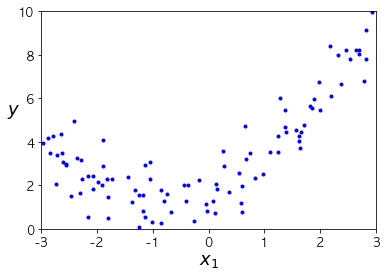

In [28]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

위의 식에 맞게끔 Scikit-Learn의 `PolynomialFeatures`를 이용해 데이터의 특성(feature, 여기서 $X$)을 제곱하면 다음과 같다.

In [29]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [30]:
X_poly[0]

array([-0.75275929,  0.56664654])

`X_poly`는 원래 값과 제곱 값을 포함한다. 이 확장된 데이터 셋에 `Linear Regression`을 적용하면 다음과 같다.

In [31]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

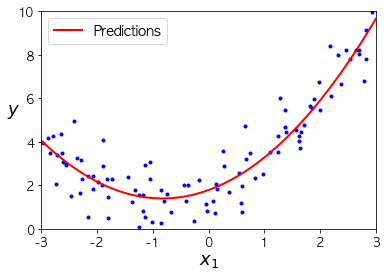

In [32]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

## 4.4 학습 곡선 (Learning Curve)

고차 다항 회귀를 사용하면 선형 회귀(linear regression)보다 Train Set에 Overfitting 될 위험이 크다. 

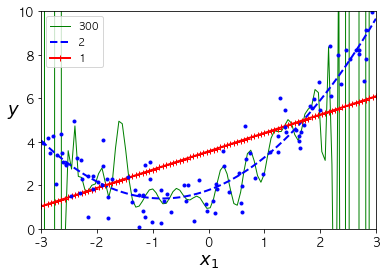

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

이전에 일반화 성능을 추정하기 위해서 교차검증(CrossValidation) 기법을 사용했다. 훈련 데이터에서 성능이 좋지만, 교차 검증 점수가 나쁘면 모델이 과대적합 된 것이다.  
만약, 양쪽 모두 좋지 못하다면 과소적합 된 모델이다. 이는 모델이 너무 복잡하거나 단순하다는 것이다.   

과대적합 여부를 확인하는 다른 방법으로는 **학습 곡석**을 살펴보는것이다. 

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              

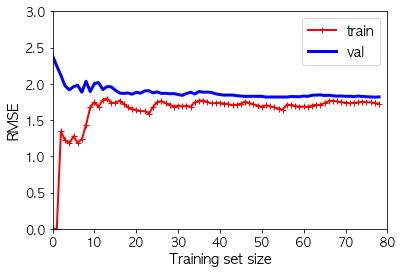

In [35]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         
plt.show()                                    

#### 훈련 데이터
그래프가 0부터 시작한다. 훈련 세트에 1개 혹은 2개의 샘플이 있을땐 모델이 완벽 하게 작동한다. 하지만, 훈련 세트에 샘플이 추가됨에 따라 잡음이 있고 비선형이기 때문에 모델이 훈련 데이터를 완벽히 학습이 불가능 해진다.   
그래서 곡선이 어느 정도 평편해질 때까지 오차가 계속 상승한다.  

#### 검증 데이터
모델이 적은 수의 샘플로 훈련된 떄는 제대로 일반화가 불가능하다. 그래서 검증 오차가 초기에는 매우 크다. 모델에 훈련 샘플이 추가됨에 따라 학습이 되고 검증오차가 천천히 감소한다.   
하지만 선형회귀의 직선은 데이터를 잘 모델링 할 수 없으므로 오차의 감소가 완만해져서 훈려세트의 그래프오 가까워 진다.

위 학습곡선은 과소적합 모델의 전형적인 못브이다. 두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접해 있다.  

#### TIP
모델이 훈련 데이터에 과소적합 되어 있따면 훈련 샘프을 더 추가해도 효과가 없다. 더 복잡한 모델을 사용하거나 더 나은 특성을 선택해야한다. 

같은 데이터에서 10차 다항 회위 모델의 학습 곡선을 그리면 다음과 같다.

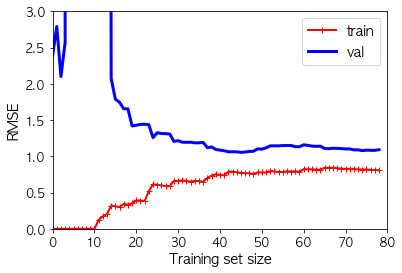

In [36]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_alg", LinearRegression())
])
plot_learning_curves(polynomial_regression, X,y)
plt.axis([0, 80, 0, 3])           
plt.show() 

위 학습 곡선은 이전 곡선과 다른 중요한 차이점이 있디.
- 훈련 데이터의 오차가 선형 회귀보다 훨씬 낮다(훈련 데이터에 한 해 성능이 더 좋다.)
- 두 곡선 사이에 공간이 존재한다. 이는 훈련데이터가 검증 데이터 보다 오차가 낮다는 뜻이고, 이는 과대적합 모델의 특징이다. 그러나, 더 큰 데이터셋을 사용하면 이 차이가 점점 줄어든다(과대적합이 줄어든다.)

## 4.5 규제(Regularization)가 있는 선형 모델
- 과대적합을 감소시키는 좋은 방법은 모델을 규제하는 것이다. (모델을 제한한다) 
- 자유도(degree of freedom)를 줄이면 데이터에 과대적합되기 더 어려워 진다.
- 다항 회귀의 모델을 규제하는 간단한 방법은 다항식의 차수를 감소시키는 것이다.

**자유도**: 통계적 추정을 할 때 표본자료 중 모집단에 대한 정보를 주는 독립적인 자료의 수

  

  
#### NOTE
일반적으로 비용함수(Cost Function)과 테스트에서 사용하는 성능지표는 다르다. 이들이 다른 이유는 훈련 시에 비용 함수에서는 최적화를 위해 **미분**이 가능 해야 하기 때문이다.   

반면, 테스트에 사용되는 성능 지표에는 최종 목표에 최대한 가까워야 한다. 때문에 로그 손실과 같은 비용함수를 사용해서 훈련시킬 Classifer의 정밀도/재현율을 사용하여 평가 해야 한다. 
  


### 4.5.1 릿지 회귀 (Ridge Regression)
**릿지 회귀**(또는 티호노프 규제)는 규제(regularization)가 추가된 선형 회귀 모델이다. 규제항(regularization term) $\lambda \sum_{i=1}^{n}{\theta_{i}^{2}}$ 이 비용함수(loss function)에 추가된다. 

따라서, 모델(알고리즘)을 데이터에 적합 시키는 것뿐만 아니라 <u>모델의 가중치가 가능한 작게 유지되도록 한다.</u> 규제항은 학습에만 사용되며 **테스트 시에는 규제항이 사용되지 않는다.**

$$
J(\theta) = \text{MSE}(\theta) + \alpha\frac{1}{2} \sum_{i=1}^{n}{\theta_{i}^{2}}
$$


위의 식에서 $\alpha$는 하이퍼파라미터이며, 모델을 얼마나 많이 규제할지 조절한다. $\alpha = 0$이면 릿지 회귀는 일반 선형 회귀와 같아지며, $\alpha$가 커지게되면 모든 가중치가 거의 0에 가까워져, 결국 데이터의 평균을 지나는 선이 된다.

릿지 회귀는 입력 특성의 스케일에 민감하기 때문에 데이터 스케일을 맞춰주는것이 중요하다.  




편향 $\theta_0$은 규제되지 않는다.($i = 1$에서 부터 시작한다.)  
  
w를 attribute들의 가중치 벡터($\theta_1, .. , \theta_n$)라고 정의하면, 규제항은 $\sqrt{(\lVert{w}\rVert_2)^2}$ 

경사 하강법에 적용하려면 MSE 그라디언트 백터에 $\alpha$w를 더하면 된다.

다음 그림은 몇 가지 다른 $\alpha%에 따른 릿지 모델을 훈련 시킨 결과다.   
- 왼쪽 그래프: 평범한 릿지 모델을 사용, 선형적 예측  
- 오른쪽 그래프: `PolynomialFeatures(degree=10)`을 사용하여 데이터 확장 후, `StandardScaler`를 사용해서 조정하여 릿지모델 생성

<img src="images/training_linear_models/ridge_regression_plot.png" width="500">

$ \alpha $가 증가 할 수록 직선에 가까워 진다.(일반화가 된다) 즉, 모델의 분산은 줄어들고 편향(<i>residual</i>)은 커진다.

릿지 회귀의 정규방정식은 다음과 같다.

$$
\hat{\mathbf{W}} = \left( \mathbf{X}^{T} \cdot \mathbf{X} + \lambda I \right)^{-1} \cdot \mathbf{X}^{T} \cdot \mathbf{y}
$$  
사이킷런에서 릿지회귀를 정규 방정식을 통해 구하는 과정은 다음과 같다. (숄레스키 분해<sub>Cholesky decomposition</sub> 사용)

In [37]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [38]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky', random_state=42)
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

`SGDRegressor()` 사용은 다음과 같다.

In [39]:
sgd_reg = SGDRegressor(penalty="l2", random_state=42)
sgd_reg.fit(X, y.flatten())
sgd_reg.predict([[1.5]]) # flatten과 같은 함수

array([1.47012588])

`penalty`의 매개변수는 사용할 규제를 지정, l2는 SGD가 비용 함수에 가중치 벡터의 l2 규제를 추가한다는 뜻, 즉 릿지회귀와 같다.

### 4.5.2 라쏘 회귀 (Lasso Regression)

**라쏘**(Lasso, Least Absolut Shrinkage and Selection Operator) 회귀는 또 다른 규제의 한 종류다. 라쏘의 규제항은 $\lambda \sum_{i=1}^{n}{\left| w_i \right|}$ 이며, 비용함수는 다음과 같다.

$$
J(w) = \text{MSE}(w) + \lambda \sum_{i=1}^{n}{\left| w_i \right|}
$$

<u>라쏘 회귀의 중요한 특징은 상대적으로 덜 중요한 특성의 가중치를 0으로 만들어 버린다.</u>(즉, 가중치가 0이 된다.) 따라서, 라쏘 회귀는 모델에 필요한 특성을 선택하여 **희소 모델**(sparse model)을 만든다.

<img src="./images/training_linear_models/lasso_regression_plot.png" width="80%">

#### Lasso vs Ridge

<img src="./images/training_linear_models/lasso_vs_ridge_plot.png" width="80%">

#### Lasso의 특징
- $l1$의 그라디언트는 0에서 정의되지 않기 때문에 진동이 발생. 이 지점에서 그라디언트는 -1 또는 1


#### Ridge의 특징
- 파라미터가 Global Minimum에 가까워질수록 그라디언트가 작아진다. 따라서, 경사 하강법이 자동으로 느려지고 수렴에 도움이 된다.(진동이 없어짐)
- $\alpha$를 증가 시킬수록 최적의 파라미터(빨간 사각형)가 원점에 가까워진다. 하지만, 완전히 0이 되지는 않는다.

위 예제에 사용된 비용함수(손실함수)를 나타내면 다음과 같다.

<img src="./images/training_linear_models/rasso_graph.gif" align="left">
<img src="./images/training_linear_models/ridge_graph.gif" align="right">


왼쪽: $l_1$ 규제 비용함수 $ | \theta_1 | + |\theta_2|  $  , 오른쪽: $l_2$ 규제 비용함수 $\sqrt{\theta_1^2 + \theta_2^2}$

라쏘의 비용함수는 $\theta_i = 0 (i= 1,2,  ... , n) $에서 미분 불가능이다. 하지만 $\theta_i = 0$ 일 때, subgradient vector를 사용하면 경사하강법을 적용가능하다. 

In [40]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

### 4.5.3 엘라스틱넷 (Elastic Net)

**엘라스틱 넷**(Elastic Net)은 릿지(Ridge) 회귀와 라쏘(Lasso) 회귀를 절충한 모델이다.   
혼합정로를 혼합 비율 $r$을 사용해 조절한다. $r=0$이면 Ridge회귀, $r=1$이면 Rasso 회귀이다.

$$
J(w) = \text{MSE}(w) + \alpha \sum_{i=1}^{n}{w_i}^2 + \left( 1 - \alpha \right) \sum_{i=1}^{n}{\left| w_i \right|}, \quad \alpha = \frac{\lambda_2}{\lambda_2 + \lambda_1}
$$

- $\lambda_2$ : $L_2$, 즉 릿지 회귀의 하이퍼파라미터
- $\lambda_1$ : $L_1$, 즉 라쏘 회귀의 하이퍼파라미터

#### 어떠한 규제를 사용해야 할까?

- 규제(regularization)가 있는 모델이 대부분의 경우에 좋으므로 규제가 없는 모델을 사용하기 보다는 규제가 있는 모델을 사용하는 것이 좋다.
- 대부분의 경우에는 $L_2$ 규제 즉, Ridge가 좋지만 모델에 사용되는 특성이 적을것이라고 예상되는 경우에는 Rasso나, 엘라스틱넷을 사용하는 것이 좋다.
    - 그 이유는, 라쏘나 엘라스틱넷은 불필요한 특성을 0으로 만들어 주기 때문이다.
- 특성 수가 Train set 보다 많거나 몇개의 특성이 강한 상관성을 보인다면 엘라스틱넷을 사용하는 것이 좋다.

In [41]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

### 4.5.4 조기 종료

또 다른 규제 방법은 경사 하강법을 이용해 학습하면서 검증 세트의 error가 최소값에 도달했을 때 스텝이 남았더라도 학습을 중지하는 **조기 종료**(early stopping)이 있다.

<img src="./images/training_linear_models/early_stopping_plot.png" width="500">

검증에러(RMSE)가 다시 증가 하기 시작 하는 순간은 과대적합 되기 시작하는 순간을 말한다. 이때 훈련을 멈추어 과대적합을 막는다.

## 4.6 로지스틱 회귀 (Logistic Regression)

샘플이 특정 클래스에 속할 확률을 추정하는데 널리 사용됨. 로지스틱 회귀는 이진 분류 알고리즘 중 하나인 모델이다.

로지스틱 회귀는 선형 회귀(linear regression)과 같이 입력 특성(feature)의 가중치 합을 계산한 뒤 로지스틱 함수(***sigmoid***)를 적용해 출력값을 계산한다. 

$$
\hat{p} = h_{w}(\mathbf{x}) = \sigma \left( \mathbf{W}^{T} \cdot \mathbf{x} \right)
$$

위의 식에서 $\sigma(\cdot)$이 바로 로지스틱(또는 로짓) 함수이며 0과 1사이의 값을 출력하는 **시그모이드 함수**(sigmoid function)이다.

$$
\sigma(x) = \frac{1}{1 + \text{exp}(-x)}
$$
  
<img src="./images/training_linear_models/logistic_function_plot.png" width="500" align="center">


로지스틱 회귀 모델이 샘플 x가 양성 클래스에 속할 확률 $\hat{p} = h_\theta(x)$를 추정하면 이에 대한 예측 $\hat{y}$를 쉽게 구할 수 있다.
$$
\hat{y} = \begin{cases} 0 \quad \hat{p} < 0.5 \\ 1 \quad \hat{p} \ge 0.5 \end{cases}
$$  
  
$t<0$이면 $ \sigma(t) < 0.5$이고, $t≥0$이면 $ \sigma(t) ≥ 0.5$이므로 로지스틱 회귀 모델은 $W^Tx$가 양수 일 때 1(*Positive Class*)이라고 예측, 음수일때 0(*Negative Class*)라고 예측한다

### 4.6.2 훈련과 비용 함수

Logistic Regression의 학습 데이터 하나에 대한 비용 함수는 다음과 같다.

$$
c(\mathbf{\theta}) = \begin{cases} -\log{\left( \hat{p} \right)} \quad \text{if, }y=1 \\ -\log{\left(1-\hat{p}\right)} \quad \text{if, }y = 0 \end{cases}
$$  


<img src="./images/training_linear_models/logit_cost_function.png" >


전체 Train Set에 대한 비용 함수는 모든 데이터에 대한 비용의 평균이며, 이것을 **로그 손실**(log loss)라고 한다. 

$$
J(\mathbf{W}) = - \frac{1}{m} \sum_{i=1}^{m}{\left[ y_{i} \log{\left( \hat{p}_i \right)} + \left( 1 - y_i \right) \log{\left( 1 - \hat{p}_i \right)} \right]}
$$

로그 손실을 $\mathbf{W}$로 미분하면 다음과 같다.

$$
\frac{\partial}{\partial w_j} = \frac{1}{m} \sum_{i=1}^{m}{\left( \sigma \left( \mathbf{W}^{T} \cdot \mathbf{x}_i \right) - \mathbf{y}_i \right)} x_{ij}
$$

### 4.6.3 결정 경계

로지스틱 회귀를 iris(붓꽃) 데이터 셋을 이용해 알아보자.

- sepal length: 꽃받침 길이
- sepal width: 꽃받침 너비
- petal length: 꽃잎 길이
- petal width: 꽃잎 너비

![](./images/iris.png)

#### Petal width(꽃잎 너비)를 이용한 Verginca 종 분류기 구현


꽃잎의 너비를 기반으로 Iris-Versicolor종을 감지하는 Classifier를 만들어 보면 다음과 같다.

In [42]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [43]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [44]:
X = iris['data'][: , 3: ] # 꽃입의 너비
y = (iris['target'] == 2).astype(np.int) # Verginca면 1 아니면 0

In [45]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률을 계산 하면 다음과 같다.

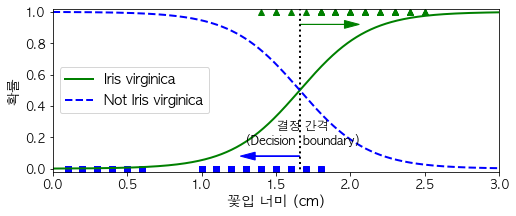

In [46]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]
1
plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "결정 간격\n(Decision  boundary)", fontsize=12, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("꽃입 너미 (cm)", fontsize=14)
plt.ylabel("확률", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

In [47]:
decision_boundary

array([1.66066066])

In [48]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

#### Petal width, Petal length를 이용한 Verginca 분류기 구현

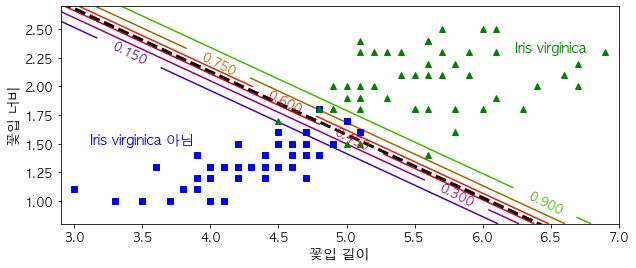

In [49]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg) #등치선


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Iris virginica 아님", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("꽃입 길이", fontsize=14)
plt.ylabel("꽃입 너비", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

다른 선형 모델 처럼 로지스틱 회귀도 $l_1, l_2$ 페널티를 적용하여 규제 할 수 있다. 사이킷런의 기본값은 $l_2$ 페널티를 기본으로 한다.

### 4.6.4 소프트맥스 회귀 (Softmax Regression)

로지스틱 회귀 모델은 여러개의 이진 분류기를 만들지 않고, 다중 클래스(multinomial class) 분류에 적용할 수 있다. 이것을 **소프트맥스 회귀**(Softmax Regression) 또는 **다항 로지스틱 회귀**(Multinomial Logistic Regression)이라고 한다.

소프트맥스 회귀의 개념은 데이터 $x$에 대해 소프트맥스 회귀 모델이 각 클래스 $k$에 대한 점수(score) $S_k \left( x \right)$를 계산하고, 그 점수값에 **소프트맥스 함수**<sub>softmax function</sub>(또는 **정규화된 지수함수**<sub>normalized exponential function</sub>)를 적용하여 각 클래스의 확률을 예측하는 모델이다. 

$$
S_k \left( \mathbf{x} \right) = \left( \mathbf{W}_{k} \right)^{T} \cdot \mathbf{x}
$$

- $\mathbf{W}_{k}$ : 각 클래스별 가중치 파라미터 벡터

위의 식을 이용해 소프트 맥스 함수를 적용한 식은 다음과 같다.

$$
\hat{p}_k = \sigma \left( s(\mathbf{x}) \right)_k = \frac{ \text{exp} \left( S_k(\mathbf{x}) \right)}{\sum_{j=1}^{K}{\text{exp} \left( S_j (\mathbf{x}) \right)}}
$$

- $K$ : 클래스의 수
- $s(\mathbf{x})$ : 데이터 샘플 $\mathbf{x}$에 대한 각 클래스의 점수를 담고 있는 벡터
- $\sigma \left( S(\mathbf{x}) \right)_k$ : 샘플 $\mathbf{x}$에 대한 클래스 $k$에 속할 추정 확률 벡터

샘플 x에 대해 각 클래스의 점수가 계산되면 소프트맥스 함수를 통과시켜 클래스 $k$에 속할 확률 $\hat{p}_k$을 추정 할 수 있다. 이 함수는 각 점수에 지수 함수를 적용한 후 정규환 한 결과 이다.  

>소프트맥스(정규화 작업)을 통해 확률로 계산이 가능하다. 즉, 타겟 클래스일 확률 몇% 인지 확률화가 가능해진다.

로지스틱 회귀 Classifer와 마찬가지로 소프트맥스 회귀 분류기도 위의 식에서 추정된 확률 벡터 중 확률이 가장 높은 클래스로 분류가 된다. 이를 식으로 나타내면 다음과 같다.

$$
\hat{y} = \underset{k}{\text{arg}} \max{\sigma \left( S(\mathbf{x}) \right)_k} = \underset{k}{\text{arg}} \max{S_k(\mathbf{x})} = \underset{k}{\text{arg}} \max{\left( \mathbf{W_k}^{T} \cdot \mathbf{x}\right) } 
$$

#### Sigmoid vs. Softmax
주요 차이점은 Sigmoid는 0과1이 출력이 되고, Softmax는 확률값 즉, 연속된(continous)값이 출력됨

|  | sigmoid | softmax |
|-|:-:|:-:|
| **구분** | binary data  | multinomial classification |
| **사용용도** | 주로 중간 층의 활성화 함수 | 주로 출력함수 |
| **출력 값 범위** | 0~1 사이의 확률값  | 0~1 사이의 확률값 (단, 결과 총합이 1이 된다) |
| **출력 값 의미** | ex. 0.5이상이면 양성, 이하면 음성의 의미 | 하나의 값에 대해 여러개(2개이상)클래스에 분류될 확률이 각 각 출력 |

#### 
Entropy
> 엔트로피는 `불확실성의 척도`입니다. 정보이론에서의 엔트로피는 `불확실성`을 나타내며, 엔트로피가 높다는 것은 정보가 많고, 확률이 낮다는 것을 의미한다.
$$
H(x) = - \sum_{i=1}^n p(x_i)* log p(x_i)
$$   
불확실성이라는 것은 어떤 데이터가 나올지 예측하기 어려운 경우라고 받아들이는 것이 더 직관적이다.


<ipython-input-50-4a1cb2fbb6ed>:2: RuntimeWarning: divide by zero encountered in log10
  log= - np.log10(p)


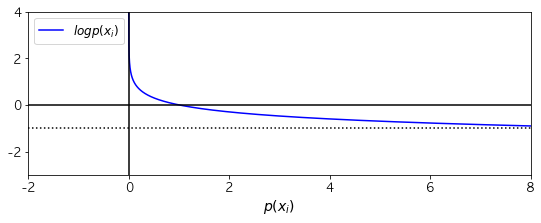

In [50]:
p = np.linspace(0, 10, 100000)
log= - np.log10(p)
plt.figure(figsize=(9, 3))
plt.plot(p, log, "b-", label="$logp(x_i)$")
plt.plot([0, 0], [-5, 5], "k-")
plt.plot([-2,8], [0,0], "k-")
plt.plot([-2,8], [-1,-1], "k:")
plt.xlabel("$p(x_i)$")
plt.legend(loc="upper left", fontsize=12)
plt.axis([-2, 8, -3, 4])
plt.show()

위 엔트로피 식을 바꾸면 다음과 같다. 
$$
H(x) =  \sum_{i=1}^n p(x_i)* (-log p(x_i))
$$
$p(x_i)$는 각각의 요소들이 나올 수 있는 확률 값이다. 모든 요소들이 나올 확률이 동일 하다면, $-log(x_i) 갑도 모두 동일 하기 때문에 식을 동일 하게 만들 수 있다.   

$p(x_i)$값의 총 합은 1이기 때문에, 수식은 $H(x) =  \sum_{i=1}^n p(x_i)* (-log p(x_i)) = -log p(x_i)$이 된다. x 값이 작아질수록 $logx$의 값이 기하 급수적으로 커진다. x가 작아진 것 보다 $logx$가 커지는 폭이 훨씬 크기 때문에, 전체 엔트로피는 증가한다. 



#### Cross-Entropy
크로스 엔트로피는 실제 분포 $q$에 대하여 알지 못하는 상태에서, 모델링을 통해 구한 분포인 $p$를 통하여 $q$를 예측 하는 것이다. **$q$와 $p$가 모두 들어가서 크로스 엔트로피**라고 한다.   

머신 러닝에서 실제 환경의 값과 $q$를, 예측값(predict) p를 모두 알고 있는 경우가 있다. **머신러닝의 모델은 몇%의 확률로 예측했는데, 실제 확률은 몇%야!** 라는 사실을 알고 있을 때 사용한다.   

크로스 엔트로피에서는 실제값과 예측값이 맞는 경우에는 0으로 수렴하고, 값이 틀릴경우에는 값이 커지기 때문에, `실제 값과 예측 값의 차이를 줄이기 위한 엔트로피`라고 보시면 될 것 같습니다.

소프트맥스 회귀의 학습을 위한 손실함수(loss function)은 **크로스 엔트로피**(cross entropy)이며 다음과 같다.  

모델이 타깃 클래스에 대해서는 높은 확률로, 다른 클래스(타킷이 아닌)에 대해서는 낮은 확률 추정을 목적으로 함.  
**크로스 엔트로피** 손실함수를 **최소화**하는 것은 <u>타깃 클래스에 대해 낮은 확률을 예측하는 모델을 엊게하는것</u>이므로 이 목적에 부합한다.    


타겟 클래스에 대한 낮은 확률 = 타킷클랙스에 대한 불확실성 = 타깃 클래스에 대한 엔트로피 $\rightarrow$ 이것을 최소화 한다

$$
J(\mathbf{W}) = - \frac{1}{m} \sum_{i=1}^{m}{\sum_{k=1}^{K}{y_k^{(i)} \log{\left( \hat{p}_k^{(i)} \right)}}}
$$

- $i$번째 샘플에 대한 타겟 클래스가 $k$일 때, $y_k^{(i)}$가 1이고, 나머지는 0이 된다.

위의 손실함수에 대한 그래디언트 벡터는 다음과 같다.

$$
\nabla_{w^{(k)}} J(\mathbf{W}) = \frac{1}{m} \sum_{i=1}^{m}{\left( \hat{p}_k^{(i)} - y_k^{(i)} \right)\mathbf{x}^{(i)}}
$$

#### Scikit-Learn `LogisticRegression`을 이용해 Softmax Regression 사용하기

Scikit-Learn에서 [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)은 셋 이상의 다중 클래스 분류에서는 기본적으로 일대다(OvA)를 디폴트 값으로 사용하지만, `multi_class`인자를 `multinomial`로 설정하면 Softmax Regression을 사용할 수 있다. 또한 `solver` 인자에 `lbfgs`로 지정해야한다.

In [51]:

X = iris['data'][:, (2,3)] #꽃잎 길이, 꽃잎 너비
y = iris['target']

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [52]:
softmax_reg.predict([[5,2]]) # 꽃잎의 길이가 5cm, 너비가 2cm인 붓꽃을 발견했다고 가정

array([2])

In [53]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

In [54]:
iris['target_names'][2]

'virginica'

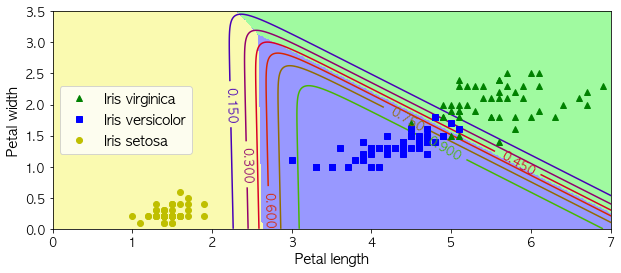

In [55]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()